**Seattle Public Life: The Impact of Digital Infrastructure on Social Presence**

**The Problem:** Seattle invests heavily in digital equity, but does home internet quality actually change how people behave in public? **The Theory:** This study tests the "Connectivity Lifeboat" hypothesis—the idea that public spaces fill the structural gaps left by poor home infrastructure.

In [44]:
import pandas as pd
import dsr_analysis as dsr
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import Image, display

Before modeling began, a multi-step diagnostic audit was performed to validate the alignment between Seattle's "Vitality" (Public Life) and "Equity" (Technology Surveys) datasets.

As visualized in the Audit Summary (below), the investigation revealed a significant limitation in the movement data: zero records for moving activities were recorded in 2023, and the 2022 volume was statistically insufficient for neighborhood-level modeling.

Consequently, the study's focus was strategically tightened to the "Staying" (stationary) observations and the Tech Access Surveys. This ensures the resulting Master Table is built only on high-density, high-fidelity data points where behavioral and demographic metrics could be reliably fused.

Success! Found Audit Summary at: /Users/aidangrambihler/seattle-public-life-analysis/visualizations/raw_checks/audit_summary.png


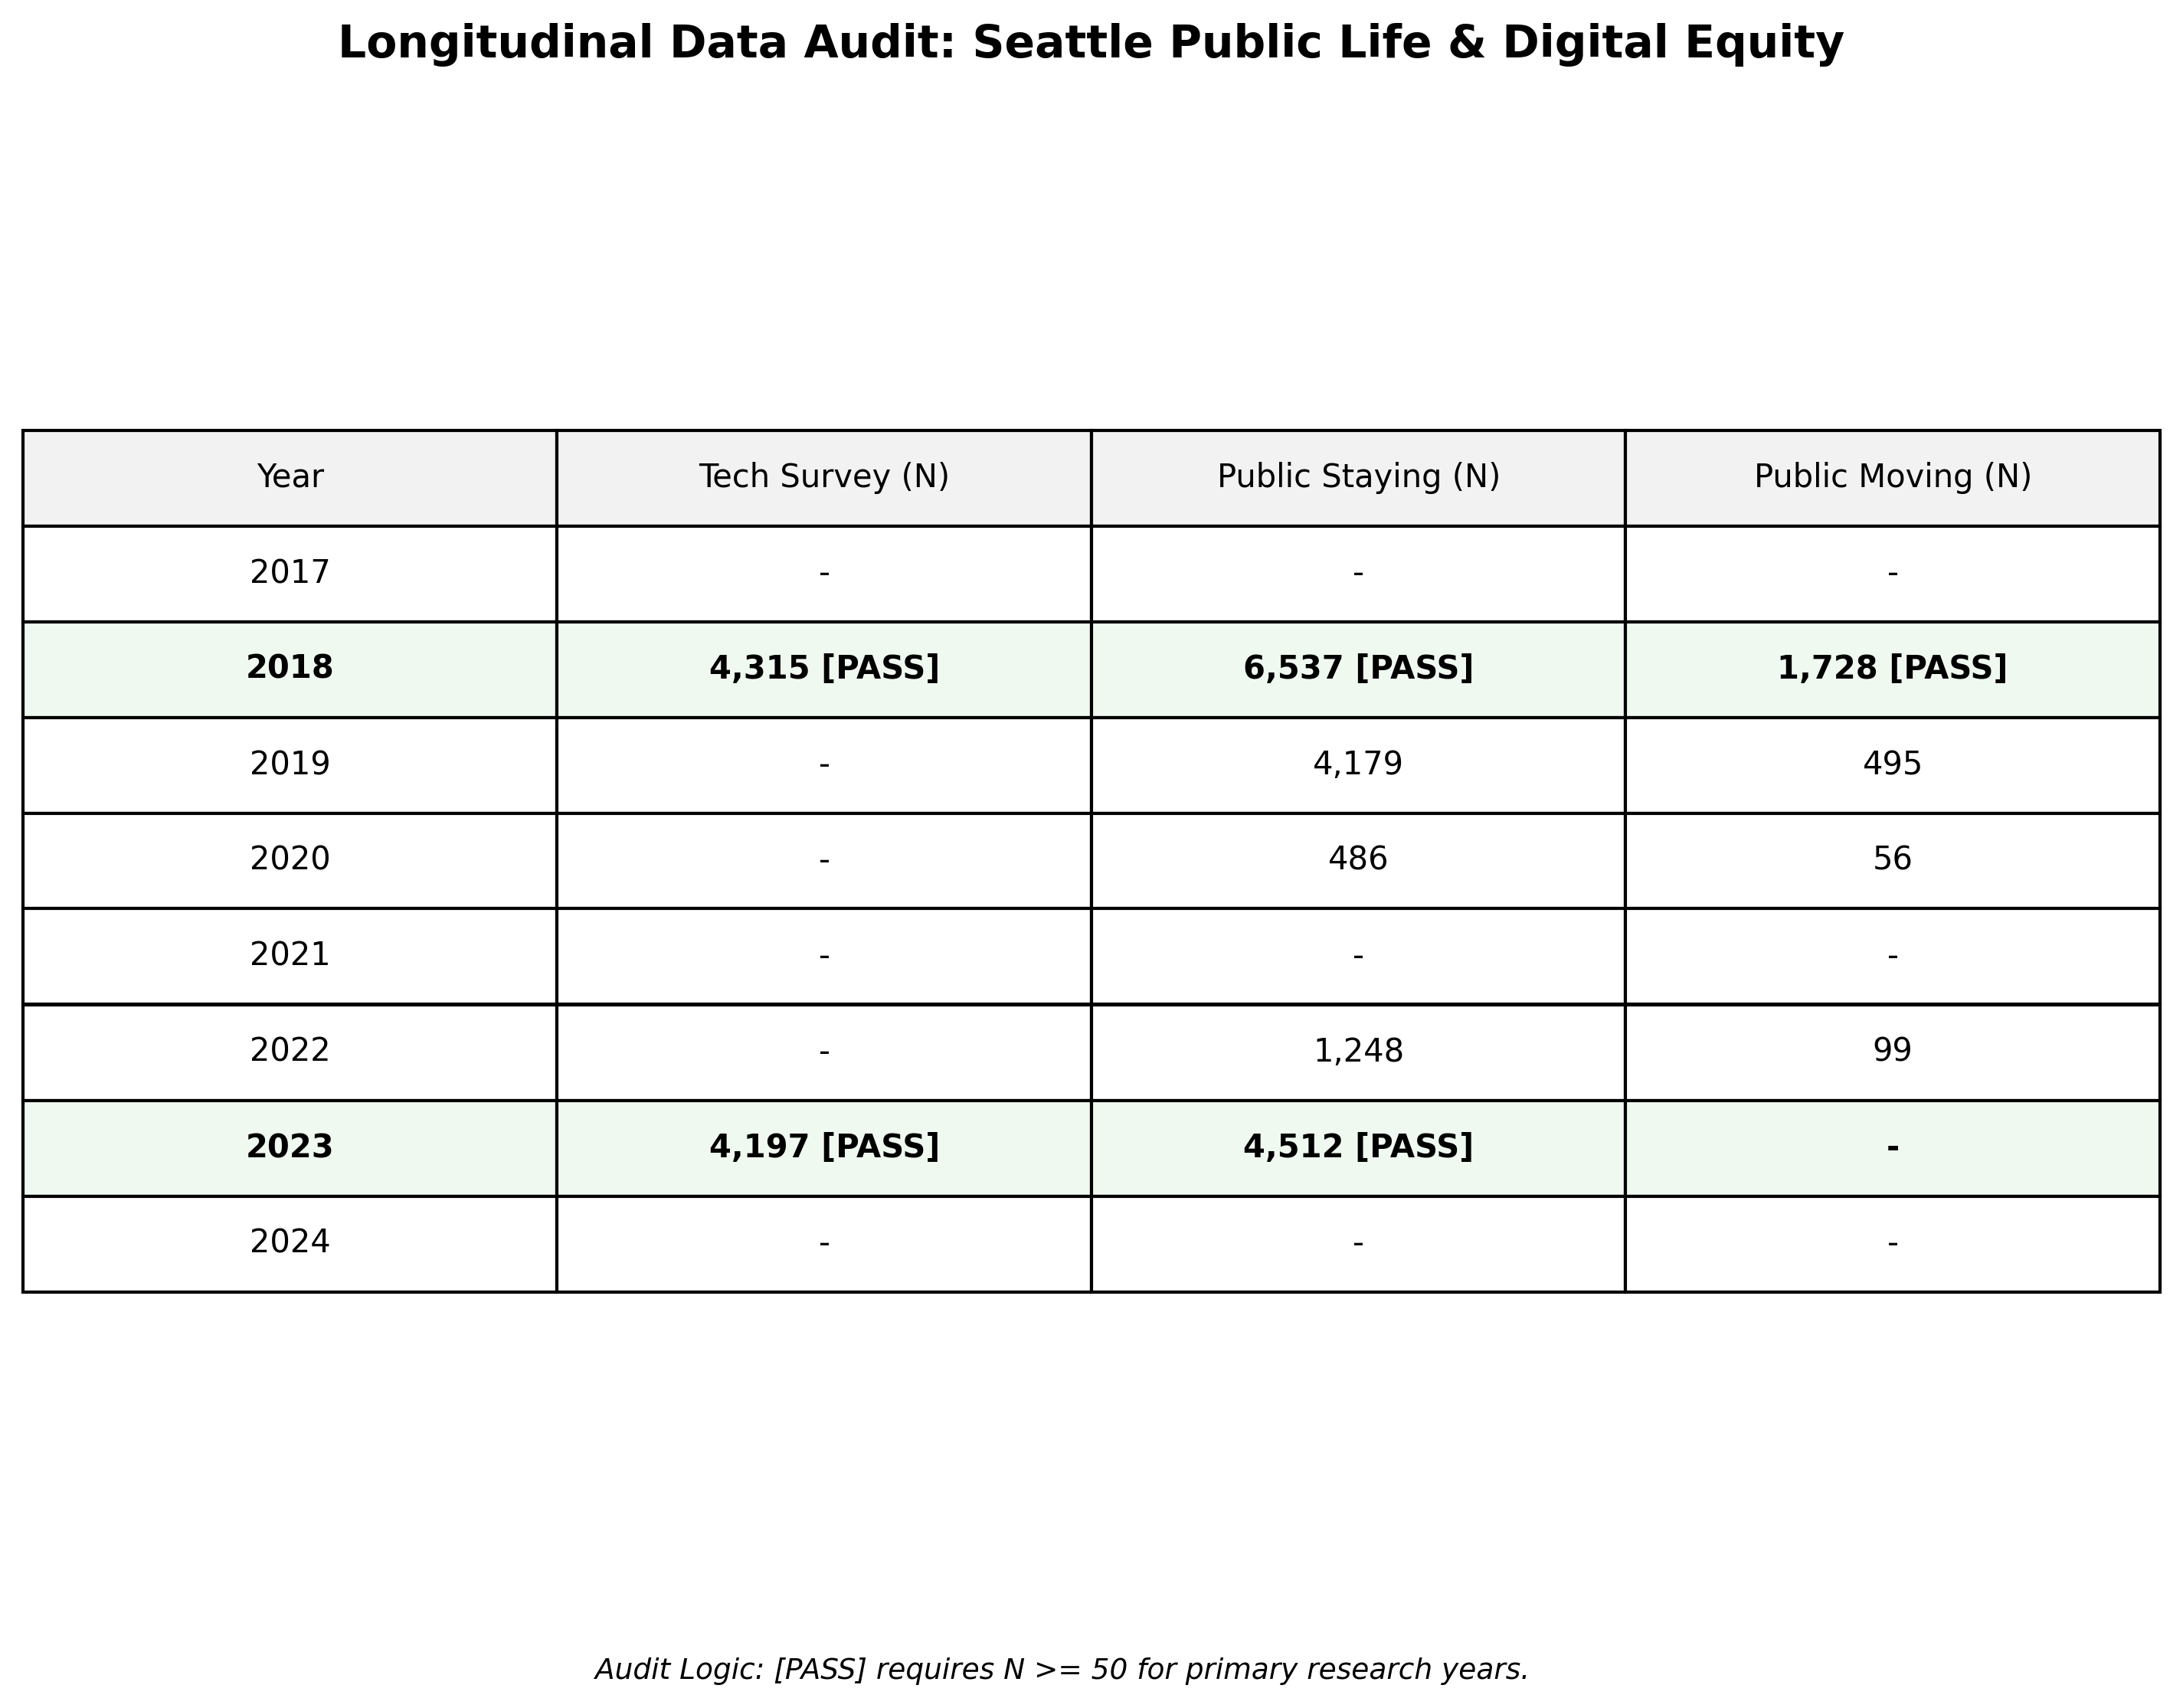

In [51]:
current_dir = Path().resolve()
root = current_dir
for _ in range(3):
    if (root / "visualizations").exists():
        break
    root = root.parent

audit_path = root / "visualizations" / "raw_checks" / "audit_summary.png"
if audit_path.exists():
    print(f"Success! Found Audit Summary at: {audit_path}")
    display(Image(filename=str(audit_path)))

**Digital-to-Social Ratio (DSR) Analysis**
**Objective**: To investigate the relationship between residential digital infrastructure quality and the behavioral composition of public life in Seattle. This study seeks to determine if home internet reliability acts as a catalyst for, or a deterrent to, the use of public spaces for digital activities.

**Primary Hypothesis**: The "Connectivity Lifeboat" Theory It is hypothesized that areas with lower residential internet reliability will exhibit a higher DSR in public spaces. In this framework, public spaces serve as a "lifeboat"—a critical infrastructure supplement where residents externalize digital tasks that cannot be reliably completed at home.

**Alternative Hypothesis**: The Prerequisite Theory Conversely, if higher reliability scores correlate with higher DSR, it would suggest that seamless, ubiquitous connectivity is a necessary prerequisite for digital public life, and that "Digital Deserts" simply lack the infrastructure to support public digital engagement.

In [26]:
from pathlib import Path

# Find the project root (assuming this notebook is in a subfolder)
# .parent points to the folder the notebook is in; .parent.parent goes up one more
root = Path(os.getcwd()).parent
data_path = root / "data" / "processed" / "master_table.csv"
geo_path = root / "data" / "processed" / "seattle_zip_codes_trimmed.geojson"

# Now load using the absolute path
df = load_master_table(data_path)
gdf = load_seattle_geometry(geo_path)

In [27]:
results = fit_dsr_models(df)

df['residuals'] = results['baseline'].resid

# Display summary
results['baseline'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                obs_dsr   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                 -0.031
Method:                 Least Squares   F-statistic:                    0.7194
Date:                Sun, 25 Jan 2026   Prob (F-statistic):              0.548
Time:                        16:51:13   Log-Likelihood:                -32.032
No. Observations:                  33   AIC:                             72.06
Df Residuals:                      29   BIC:                             78.05
Df Model:                           3                                         
Covariance Type:                  HC3                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  4.1854      4.129      1.014      0.311      -3.908      12.279
C(survey_year)[T.2023]     0.3660      0.293      1.249      0.212      -0.208       0.941
res_avg_reliability       -0.8672      1.038     -0.836      0.403      -2.901       1.167
res_median_income       1.002e-06    4.3e-06      0.233      0.816   -7.43e-06    9.43e-06
==============================================================================
Omnibus:                       19.631   Durbin-Watson:                   1.227
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.301
Skew:                           1.664   Prob(JB):                     3.21e-06
Kurtosis:                       5.706   Cond. No.                     3.48e+06
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 3.48e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
# Compare the OLS and Mixed-Effects results
print(f"OLS R-Squared: {results['baseline'].rsquared:.4f}")
print(f"Mixed-Effects Log-Likelihood: {results['mixed_effects'].llf:.4f}")

# Pro-Tip: Check the 'Variance Component' in the Mixed model
# This tells you how much the 'ZIP code' itself explains the DSR
print(results['mixed_effects'].summary().tables[1])

OLS R-Squared: 0.0655
Mixed-Effects Log-Likelihood: -25.9156
                               Coef. Std.Err.       z  P>|z|  [0.025  0.975]
Intercept                      5.428    2.669   2.034  0.042   0.197  10.658
C(survey_year)[T.2023]         0.489    0.169   2.895  0.004   0.158   0.820
res_avg_reliability           -1.118    0.643  -1.739  0.082  -2.378   0.142
res_pct_eth_african_american  -0.037    0.024  -1.559  0.119  -0.083   0.009
Group Var                      0.301    0.690                               


In [29]:
mi = calculate_spatial_autocorrelation(df, gdf)
print(f"Moran's I: {mi.I:.4f} (p-value: {mi.p_sim:.4f})")

Moran's I: 0.1919 (p-value: 0.0120)


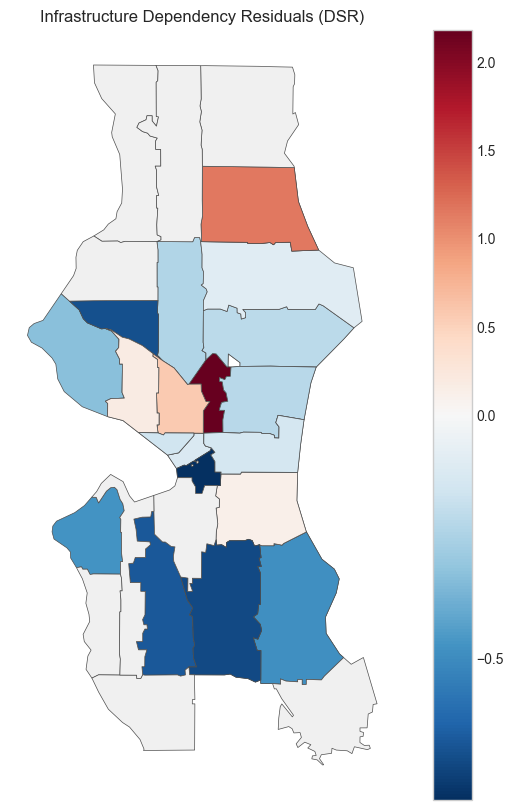

In [30]:
# Generate the residual map
fig = plot_residuals(df, gdf)
plt.show()

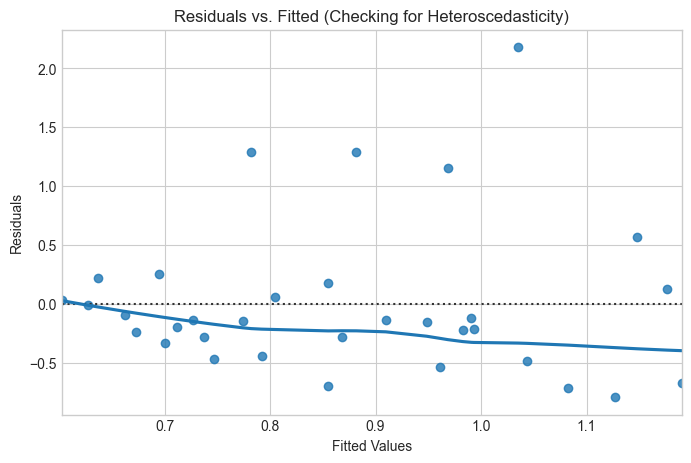

In [31]:
import seaborn as sns

# Diagnostic Plot: Residuals vs Fitted
plt.figure(figsize=(8, 5))
sns.residplot(x=results['baseline'].fittedvalues, y=df['residuals'], lowess=True)
plt.title("Residuals vs. Fitted (Checking for Heteroscedasticity)")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()